In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the ticker symbol and fetch data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-09-09')

# Display the first few rows of the dataset
print("First few rows of data:")
print(data.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

# Fill missing values
data.ffill(inplace=True)

# Save to CSV
data.to_csv('AAPL_data.csv')

print("\nData has been saved to 'AAPL_data.csv'.")


[*********************100%%**********************]  1 of 1 completed

First few rows of data:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876106  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167603  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742668  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565208  132079200

Missing values in the dataset:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Data has been saved to 'AAPL_data.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the CSV file
data = pd.read_csv('AAPL_data.csv', parse_dates=True, index_col='Date')

# Forward fill missing values if any
data.ffill(inplace=True)

# Add lagged features
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

# Add a simple moving average
data['SMA_1'] = data['Close'].rolling(window=1).mean()

# Add target variable
data['Next Close'] = data['Close'].shift(-1)

# Drop rows with NaN values (due to shifting and rolling)
data.dropna(inplace=True)

# Features (X) and target (y)
features = ['Close', 'Lag1', 'Lag2', 'Lag3', 'SMA_1']
X = data[features]
y = data['Next Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Define and train the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=0)

# Predict on the full dataset
data['Predicted Close'] = model.predict(X_scaled)

# Forecast the next day's closing price
latest_data = data[features].iloc[-1].values.reshape(1, -1)  # Use the last row of data as input
latest_data_scaled = scaler.transform(latest_data)  # Scale the data
next_day_prediction = model.predict(latest_data_scaled)

# Print the last known close price, predicted close price, and next day forecast
print(f"Last Known Closing Price: ${data['Close'].iloc[-1]:.2f}")
print(f"Last Predicted Closing Price: ${data['Predicted Close'].iloc[-1]:.2f}")
print(f"Next Day Forecasted Closing Price: ${next_day_prediction[0][0]:.2f}")


# Plotting

# 1. Plot the Actual Closing Prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
plt.title('Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.annotate(f'Last Actual Close: ${data["Close"].iloc[-1]:.2f}',
            xy=(data.index[-1], data['Close'].iloc[-1]),
            xytext=(data.index[-1], data['Close'].iloc[-1] + 10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, color='blue')
plt.savefig('actual_closing_prices.png')
plt.show()

# 2. Plot the Predicted Closing Prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.annotate(f'Last Predicted Close: ${data["Predicted Close"].iloc[-1]:.2f}',
            xy=(data.index[-1], data['Predicted Close'].iloc[-1]),
            xytext=(data.index[-1], data['Predicted Close'].iloc[-1] + 10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, color='red')
plt.savefig('predicted_closing_prices.png')
plt.show()

# 3. Plot both Actual and Predicted Closing Prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
plt.plot(data.index, data['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.annotate(f'Last Actual Close: ${data["Close"].iloc[-1]:.2f}',
            xy=(data.index[-1], data['Close'].iloc[-1]),
            xytext=(data.index[-1], data['Close'].iloc[-1] + 10),
            arrowprops=dict(facecolor='blue', shrink=0.05),
            fontsize=10, color='blue')
plt.annotate(f'Last Predicted Close: ${data["Predicted Close"].iloc[-1]:.2f}',
            xy=(data.index[-1], data['Predicted Close'].iloc[-1]),
            xytext=(data.index[-1], data['Predicted Close'].iloc[-1] + 10),
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=10, color='red')
plt.annotate(f'Next Day Forecast: ${next_day_prediction[0][0]:.2f}',
            xy=(data.index[-1] + pd.DateOffset(days=1), next_day_prediction[0][0]),
            xytext=(data.index[-1] + pd.DateOffset(days=1), next_day_prediction[0][0] + 10),
            arrowprops=dict(facecolor='green', shrink=0.05),
            fontsize=10, color='green')
plt.savefig('actual_vs_predicted.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

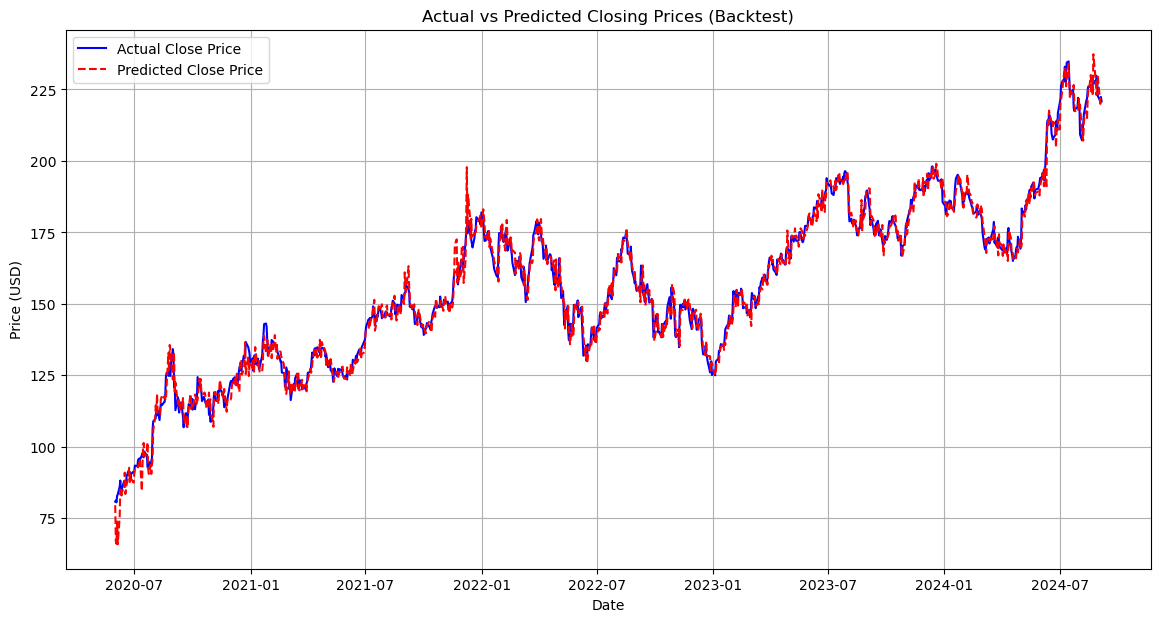

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load the CSV file
data = pd.read_csv('AAPL_data.csv', parse_dates=True, index_col='Date')

# Forward fill missing values if any
data.ffill(inplace=True)

# Add lagged features
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

# Add a simple moving average
data['SMA_1'] = data['Close'].rolling(window=1).mean()

# Add target variable
data['Next Close'] = data['Close'].shift(-1)

# Drop rows with NaN values (due to shifting and rolling)
data.dropna(inplace=True)

# Features (X) and target (y)
features = ['Close', 'Lag1', 'Lag2', 'Lag3', 'SMA_1']
X = data[features]
y = data['Next Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the model (train only once)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_scaled.shape[1],)),  # Specify input shape here
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

# Prepare for rolling predictions
predictions = []
actuals = []
look_back = 100  # Number of data points to train on

for i in range(look_back, len(data)):
    # Prepare training and testing sets
    X_train = X_scaled[:i]
    y_train = y[:i]
    X_test = X_scaled[i:i+1]
    y_test = y[i:i+1]
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, verbose=0)
    
    # Make prediction
    y_pred = model.predict(X_test)
    
    # Collect predictions and actual values
    predictions.append(y_pred[0, 0])
    actuals.append(y_test.values[0])

# Calculate and print performance metrics
mse = mean_squared_error(actuals, predictions)
mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[look_back:], actuals, label='Actual Close Price', color='blue')
plt.plot(data.index[look_back:], predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices (Backtest)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('backtest_actual_vs_predicted.png')
plt.show()
